# ARoF DPD-MP: Performance

In [1]:
import sys

project_path = r"C:\Users\PC\Documents\Mestrado"
file_path    = project_path + r"\DPD"
sys.path.append(project_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal           import welch, firwin, hilbert
from scipy.constants        import pi
from tqdm.notebook          import tqdm
from tabulate               import tabulate

from optic.comm.modulation  import modulateGray
from optic.models.channels  import linearFiberChannel
from optic.models.devices   import mzm, photodiode
from optic.comm.metrics     import fastBERcalc, theoryBER, calcEVM
from optic.dsp.core         import pnorm, signal_power, upsample, pulseShape, firFilter, decimate, finddelay
from optic.utils            import parameters, dBm2W
from optic.comm.ofdm        import modulateOFDM, demodulateOFDM
from optic_private.dsp.core import calcACLR

from DPD_utils.MP_tools     import powerAmplifier, MP_filter, LS_solver, MP_training, calcSNR_per_carrier
from DPD_utils.plots        import plotDPD_const, plotDPD_spec, plotDPD_SNR

In [ ]:
font = {'size':14}
plt.rc('font', **font)
plt.rcParams["font.family"] = "serif"

In [3]:
def RoF_channel(sigTx, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD):
    # Sinal RF
    t = np.arange(0, sigTx.size)*1/Fs
    sigTx_RF = np.real( sigTx * np.exp(1j*2*pi*paramRF.fc_e*t) )
    sigTx_RF = np.sqrt(dBm2W(paramRF.Pin_RF))*pnorm(sigTx_RF)

    # Sonal óptico
    Ai     = np.sqrt(dBm2W(paramMZM.Pin_OF))*np.ones(sigTx_RF.size)
    sigTxo = mzm(Ai, sigTx_RF, paramMZM)
    
    numtaps = 4096
    hopt_tx = firwin(numtaps, paramRF.fc_e + 2*Rs, fs = Fs)
    sigTxo = np.sqrt(signal_power(sigTxo))*pnorm(firFilter(hopt_tx, sigTxo))
    
    sigRxo = linearFiberChannel(sigTxo, paramChannel)

    # Sinal elétrico (fotocorrente) 
    I_Rx = photodiode(sigRxo, paramPD)
    I_Rx = pnorm(I_Rx)
    I_Rx -= I_Rx.mean()
    
    # Sinal elétrico pós-FPF
    f1 = paramRF.fc_e - 2*Rs
    f2 = paramRF.fc_e + 2*Rs
    hbp_RF = firwin(numtaps, (f1, f2), pass_zero = 'bandpass', fs = Fs)

    I_RF = firFilter(hbp_RF, I_Rx)

    # Sinal elétrico pós-PA
    sigRx = hilbert(I_RF)*np.exp(-1j*2*pi*paramRF.fc_e*t)
    sigRx = np.sqrt(dBm2W(paramRF.Pin_PA))*pnorm(sigRx)
    sigRx = powerAmplifier(sigRx)
    
    sigRx_PA = sigRx.copy()
    
    hlp = firwin(numtaps, Rs/1.5, fs = Fs)
    sigRx = firFilter(hlp, sigRx)

    # Correção do delay
    delay = finddelay(sigRx, sigTx)
    sigRx = np.roll(sigRx, -delay)
    
    rot = np.mean(sigTx/sigRx)
    sigRx = rot/np.abs(rot)*sigRx
    
    # Parâmetros da decimação
    paramDec = parameters()
    paramDec.SpS_in  = SpS
    paramDec.SpS_out = 1
    
    symbRx_OFDM = decimate(sigRx, paramDec).ravel()
    symbRx = demodulateOFDM(symbRx_OFDM, paramOFDM)

    return sigRx_PA, symbRx

### 1 - Geração do Sinal OFDM

In [7]:
# Parâmetros de modulação
modOrder = 64                          # Ordem da modulação
modType  = 'qam'                       # Tipo de modulação
Rb = 5e9                               # Taxa de transmissão de bits
SpS = 64                               # Amostras por símbolo

# Parâmetros OFDM
paramOFDM = parameters()
paramOFDM.Nfft = 1024                  # Tam. da FFT
paramOFDM.Np   = 64                    # Núm. de subportadoras piloto
paramOFDM.G    = 32                    # Tam. do prefixo cíclico
paramOFDM.hermitSymmetry = False
paramOFDM.SpS = SpS
paramOFDM.pilotCarriers = np.linspace(0, paramOFDM.Nfft-1, paramOFDM.Np, dtype=np.int64) # Pilot subcarriers
Ns = paramOFDM.Nfft - paramOFDM.Np     # Núm. de subportadoras de informação

Rs = Rb / ( Ns/(paramOFDM.Nfft + paramOFDM.G) * np.log2(modOrder) )    # Taxa de transmissão de símbolos
Fs = Rs * SpS                                                          # Taxa de amostragem

# Geração dos bits e dos símbolos QAM
batchSize = 1000//(int(paramOFDM.Nfft/128))
bits = np.random.randint(2, size = batchSize * Ns * int(np.log2(modOrder) ) )

symbTx = modulateGray(bits, modOrder, modType)
symbTx = pnorm(symbTx)

pilotSymb = 0.25*(max(symbTx.real) + 1j*max(symbTx.imag))
paramOFDM.pilot = pilotSymb

In [8]:
sigTx = modulateOFDM(symbTx, paramOFDM)
sigTx = pnorm(sigTx)

t = np.arange(0, sigTx.size)*1/Fs
t_CP   = SpS * paramOFDM.G * (1/Fs)
t_symb = SpS * (paramOFDM.Nfft + paramOFDM.G) * (1/Fs)

In [9]:
table = [['Grandeza', 'Parâmetro', 'Valor'],
         ['Taxa de amostragem', 'Fs', f'{Fs*1e-9:.2f} Gsamples/s'],
         ['Taxa de símbolos', 'Rs', f'{Rs*1e-9:.2f} Gsymb/s'],
         ['Taxa de transmissão', 'Rb', f'{Rb*1e-9:.2f} Gb/s'],
         ['Ordem da constelação', 'M', f'{modOrder}'],
         ['Tamanho da FFT', 'Nfft', f'{paramOFDM.Nfft}'],
         ['Tamanho do prefixo cíclico', 'G', f'{paramOFDM.G}'],
         ['Num. port. de informação', 'Ns', f'{Ns}'],
         ['Num. port. piloto', 'Np', f'{paramOFDM.Np}'],
         ['Espaçamento entre subportadoras', 'Delta_f', f'{(Rs/paramOFDM.Nfft)*1e-6:.2f} MHz'],
         ['Duração do símbolo OFDM', 'T_symb', f'{1e9*t_symb:.2f} ns'],
         ['Duração do prefixo cíclico', 'T_CP', f'{1e9*t_CP:.2f} ns'] ]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═════════════════════════════════╤═════════════╤══════════════════╕
│ Grandeza                        │ Parâmetro   │ Valor            │
╞═════════════════════════════════╪═════════════╪══════════════════╡
│ Taxa de amostragem              │ Fs          │ 58.67 Gsamples/s │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Taxa de símbolos                │ Rs          │ 0.92 Gsymb/s     │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Taxa de transmissão             │ Rb          │ 5.00 Gb/s        │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Ordem da constelação            │ M           │ 64               │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Tamanho da FFT                  │ Nfft        │ 1024             │
├─────────────────────────────────┼─────────────┼──────────────────┤
│ Tamanho do prefixo cíclico      │ G           │ 32               │
├─────────────────────────────────

In [10]:
## Parametrização dos dispositivos

# Parâmetros do MZM
paramMZM = parameters()
paramMZM.Vpi = 3
paramMZM.Vb = -paramMZM.Vpi/2
paramMZM.Pin_OF = 15

# Parâmetros do canal óptico
paramChannel = parameters()
paramChannel.L = 30
paramChannel.alpha = 0.2
paramChannel.D = 16
paramChannel.Fc = 193.1e12
paramChannel.Fs = Fs

#
paramRF = parameters()
paramRF.fc_e = 5e9
paramRF.Pin_RF = 17
paramRF.Pin_PA = 5

# Parâmetros do fotodiodo
paramPD = parameters()
paramPD.ideal = False
paramPD.B = paramRF.fc_e + 2*Rs
paramPD.Ipd_sat = 50e-3
paramPD.Fs = Fs

#### Training Sweep

In [11]:
powerRF_sweep   = np.arange( 10, 26, 1)
powerInPA_sweep = np.arange(-10, 11, 1)

In [12]:
M, P = (8, 3)
L, K = (8, 3)

N = 20000
SpS_mp = 4

paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = SpS_mp

# 
paramTrain = parameters()
paramTrain.M = M
paramTrain.P = P

paramTrain.N = N
paramTrain.numIter = 5

paramTrain.mu  = 1e-3
paramTrain.lbd = 0.9999
paramTrain.S   = 5*np.eye(paramTrain.P*paramTrain.M, dtype = complex)*1e-2

paramTrain.pgrsBar    = False
paramTrain.storeCoeff = False

In [157]:

for i, inPowerPA in enumerate(tqdm(powerInPA_sweep)):
    for j, inPowerRF in enumerate(powerRF_sweep):
        paramRF.Pin_RF = inPowerRF
        paramRF.Pin_PA = inPowerPA

        sigRx_PA, symbRx = RoF_channel(sigTx, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)

        # Decimação para o sinal de treinamento
        hlp = firwin(4096, SpS_mp*Rs/2, fs = Fs)
        sigRef = decimate(pnorm(firFilter(hlp, sigTx)), paramDec)
        sigIn  = decimate(pnorm(firFilter(hlp, sigRx_PA)), paramDec)
        
        sigRef = pnorm(sigRef).ravel()
        sigIn  = pnorm(sigIn).ravel()

        # Correção de atrasos
        delay = finddelay(sigIn, sigRef)
        sigIn = np.roll(sigIn, -delay)
        
        rot = np.mean(sigRef/sigIn)
        sigIn = rot/np.abs(rot)*sigIn

        # Cálculo dos coeficientes de identificação do canal
        a_kl  = LS_solver(sigRef[0:N], sigIn[0:N], K, L)

        # Aprendizado indireto
        paramTrain.alg = "RLS"
        paramTrain.a_kl = a_kl
        paramTrain.directLearn = False

        w_ila, _ = MP_training(sigRef, paramTrain, sigIn)

        # Aprendizado direto
        paramTrain.alg = "NFxRLS"
        paramTrain.a_kl = a_kl
        paramTrain.directLearn = True

        w_dla, errSq = MP_training(sigRef, paramTrain)

        # Saving coefficients
        np.savetxt(file_path + f'\\Filter_Coefficients_MP\\w_dla_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.txt',
                   w_dla, fmt = '%f')
        np.savetxt(file_path + f'\\Filter_Coefficients_MP\\w_ila_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.txt',
                   w_ila, fmt = '%f')
        np.savetxt(file_path + f'\\Filter_Coefficients_MP\\a_kl_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.txt',
                   a_kl, fmt = '%f')

  0%|          | 0/21 [00:00<?, ?it/s]

#### Test Sweep

In [13]:
# Parâmetros OFDM
paramOFDM = parameters()
paramOFDM.Nfft = 1024                  # Tam. da FFT
paramOFDM.Np   = 64                    # Núm. de subportadoras piloto
paramOFDM.G    = 32                    # Tam. do prefixo cíclico
paramOFDM.hermitSymmetry = False
paramOFDM.SpS = SpS_mp
paramOFDM.pilotCarriers = np.linspace(0, paramOFDM.Nfft-1, paramOFDM.Np, dtype=np.int64) # Pilot subcarriers
Ns = paramOFDM.Nfft - paramOFDM.Np     # Núm. de subportadoras de informação

Rs = Rb / ( Ns/(paramOFDM.Nfft + paramOFDM.G) * np.log2(modOrder) )    # Taxa de transmissão de símbolos
Fs = Rs * SpS                                                          # Taxa de amostragem

# Geração dos bits e dos símbolos QAM
batchSize = 1000//(int(paramOFDM.Nfft/128))
bits = np.random.randint(2, size = batchSize * Ns * int(np.log2(modOrder) ) )

symbTx = modulateGray(bits, modOrder, modType)
symbTx = pnorm(symbTx)

pilotSymb = 0.25*(max(symbTx.real) + 1j*max(symbTx.imag))
paramOFDM.pilot = pilotSymb

sigTx = modulateOFDM(symbTx, paramOFDM)
sigTx = pnorm(sigTx)

In [14]:
discard = 500
index = np.arange(discard, symbTx.size - discard)

EVM_woDPD = np.zeros((powerInPA_sweep.size, powerRF_sweep.size))
EVM_DLA   = np.zeros(EVM_woDPD.shape)
EVM_ILA   = np.zeros(EVM_woDPD.shape)

ACLR_woDPD = np.zeros(EVM_woDPD.shape)
ACLR_DLA   = np.zeros(EVM_woDPD.shape)
ACLR_ILA   = np.zeros(EVM_woDPD.shape)

SNR_woDPD = np.zeros(EVM_woDPD.shape)
SNR_DLA   = np.zeros(EVM_woDPD.shape)
SNR_ILA   = np.zeros(EVM_woDPD.shape)

In [15]:
h_dpd = firwin(4096, 2*Rs, fs = Fs)

for i, inPowerPA in enumerate(tqdm(powerInPA_sweep)):
    for j, inPowerRF in enumerate(powerRF_sweep):
        paramRF.Pin_RF = inPowerRF
        paramRF.Pin_PA = inPowerPA

        # carregar os vetores w_dla, w_ila...
        w_dla = np.loadtxt(file_path + f'\\Filter_Coefficients_MP\\w_dla_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.txt', 
                           dtype=np.complex128)

        w_ila = np.loadtxt(file_path + f'\\Filter_Coefficients_MP\\w_ila_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.txt', 
                           dtype=np.complex128)

        
        sigTx_DLA = MP_filter(sigTx, np.conj(w_dla).reshape((P, M)))
        sigTx_ILA = MP_filter(sigTx, np.conj(w_ila).reshape((P, M)))
        
        # Upsampling
        sigTx_woDPD = upsample(sigTx.ravel(), SpS//SpS_mp).reshape(-1,) 
        sigTx_woDPD = firFilter(h_dpd, sigTx_woDPD)
        
        sigTx_DLA = upsample(sigTx_DLA.ravel(), SpS//SpS_mp).reshape(-1,) 
        sigTx_DLA = firFilter(h_dpd, sigTx_DLA)

        sigTx_ILA = upsample(sigTx_ILA.ravel(), SpS//SpS_mp).reshape(-1,) 
        sigTx_ILA = firFilter(h_dpd, sigTx_ILA)
        
        sigRx_PA, symbRx = RoF_channel(sigTx_woDPD, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)
        sigRx_PA_DLA, symbRx_DLA = RoF_channel(sigTx_DLA, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)
        sigRx_PA_ILA, symbRx_ILA = RoF_channel(sigTx_ILA, Rs, SpS, Fs, paramMZM, paramChannel, paramRF, paramPD)
        
        symbRx = pnorm(symbRx)
        symbRx_DLA = pnorm(symbRx_DLA)
        symbRx_ILA = pnorm(symbRx_ILA)
        
        # Metrics
        freq, P_sigTx            = welch(pnorm(sigTx_woDPD)[0::SpS//SpS_mp], fs = SpS_mp*Rs, nfft = 16*1024, return_onesided = False)
        freq, P_sigRx_PA         = welch(pnorm(sigRx_PA)[0::SpS//SpS_mp], fs = SpS_mp*Rs, nfft = 16*1024, return_onesided = False)
        freq_DLA, P_sigRx_PA_DLA = welch(pnorm(sigRx_PA_DLA)[0::SpS//SpS_mp], fs = SpS_mp*Rs, nfft = 16*1024, return_onesided = False)
        freq_ILA, P_sigRx_PA_ILA = welch(pnorm(sigRx_PA_ILA)[0::SpS//SpS_mp], fs = SpS_mp*Rs, nfft = 16*1024, return_onesided = False)
        
        ACLR_woDPD[i, j] = calcACLR(P_sigRx_PA, freq, 0.5e9)
        ACLR_DLA[i, j]   = calcACLR(P_sigRx_PA_DLA, freq_DLA, 0.5e9)
        ACLR_ILA[i, j]   = calcACLR(P_sigRx_PA_ILA, freq_ILA, 0.5e9)
        
        _, _, SNR_woDPD[i, j] = fastBERcalc(symbRx[index],     symbTx[index], modOrder, modType)
        _, _, SNR_DLA[i, j]   = fastBERcalc(symbRx_DLA[index], symbTx[index], modOrder, modType)
        _, _, SNR_ILA[i, j]   = fastBERcalc(symbRx_ILA[index], symbTx[index], modOrder, modType)

        EVM_woDPD[i, j] = 10*np.log10(calcEVM(symbRx,     modOrder, modType))[0]
        EVM_DLA[i, j]   = 10*np.log10(calcEVM(symbRx_DLA, modOrder, modType))[0]
        EVM_ILA[i, j]   = 10*np.log10(calcEVM(symbRx_ILA, modOrder, modType))[0]

        # Plots
        # Constellation
        plotDPD_const(symbTx, symbRx, symbRx_DLA, symbRx_ILA, show = False, savefig = True, 
                     file_path = file_path + f"\\Plots_MP\\Constellation_plots\\Const_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")

        # Spectrum
        plotDPD_spec(freq, P_sigTx, P_sigRx_PA, P_sigRx_PA_DLA, P_sigRx_PA_ILA, Rs, show = False, savefig = True, 
                    file_path = file_path + f"\\Plots_MP\\Spectrum_plots\\Spectrum_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")

        # SNR per carrier
        SNR_per_carrier_woDPD = calcSNR_per_carrier(symbTx, symbRx, Ns)
        SNR_per_carrier_DLA   = calcSNR_per_carrier(symbTx, symbRx_DLA, Ns)
        SNR_per_carrier_ILA   = calcSNR_per_carrier(symbTx, symbRx_ILA, Ns)
        
        plotDPD_SNR(SNR_per_carrier_woDPD, SNR_per_carrier_DLA, Ns, "DLA", show = False, savefig = True, 
                    file_path = file_path + f"\\Plots_MP\\SNR_per_carriers_plots\\SNR_DLA_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")
        
        plotDPD_SNR(SNR_per_carrier_woDPD, SNR_per_carrier_ILA, Ns, "ILA", show = False, savefig = True, 
                    file_path = file_path + f"\\Plots_MP\\SNR_per_carriers_plots\\SNR_ILA_f_{paramRF.fc_e/1e9:.1f}GHz_PowerPA_{inPowerPA}dB_PowerRF_{inPowerRF}dB.pdf")


# save metrics arrays...
np.savetxt(file_path + f'\\Metrics_MP\\EVM_woDPD_f_{paramRF.fc_e/1e9:.1f}GHz.txt', EVM_woDPD, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_MP\\EVM_DLA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', EVM_DLA, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_MP\\EVM_ILA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', EVM_ILA, fmt = '%f')

np.savetxt(file_path + f'\\Metrics_MP\\ACLR_woDPD_f_{paramRF.fc_e/1e9:.1f}GHz.txt', ACLR_woDPD, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_MP\\ACLR_DLA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', ACLR_DLA, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_MP\\ACLR_ILA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', ACLR_ILA, fmt = '%f')

np.savetxt(file_path + f'\\Metrics_MP\\SNR_woDPD_f_{paramRF.fc_e/1e9:.1f}GHz.txt', SNR_woDPD, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_MP\\SNR_DLA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', SNR_DLA, fmt = '%f')
np.savetxt(file_path + f'\\Metrics_MP\\SNR_ILA_f_{paramRF.fc_e/1e9:.1f}GHz.txt', SNR_ILA, fmt = '%f')

  0%|          | 0/21 [00:00<?, ?it/s]

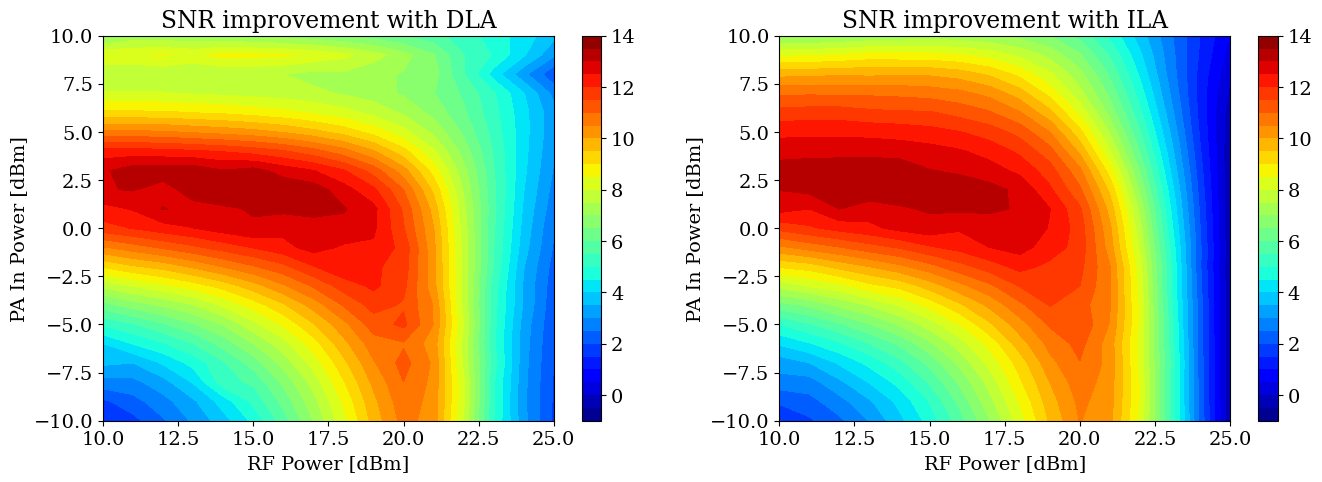

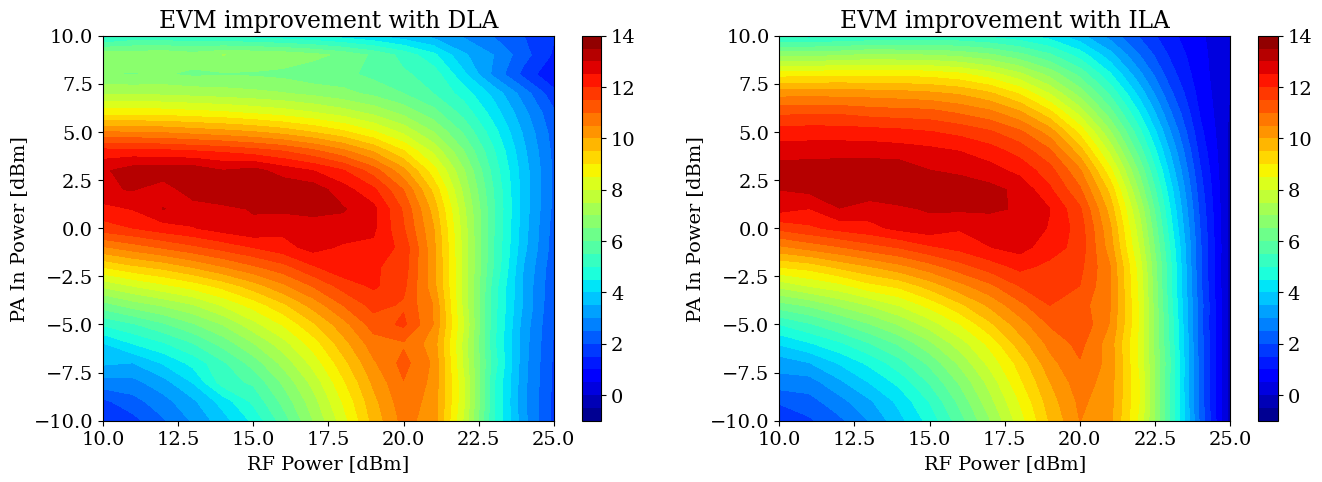

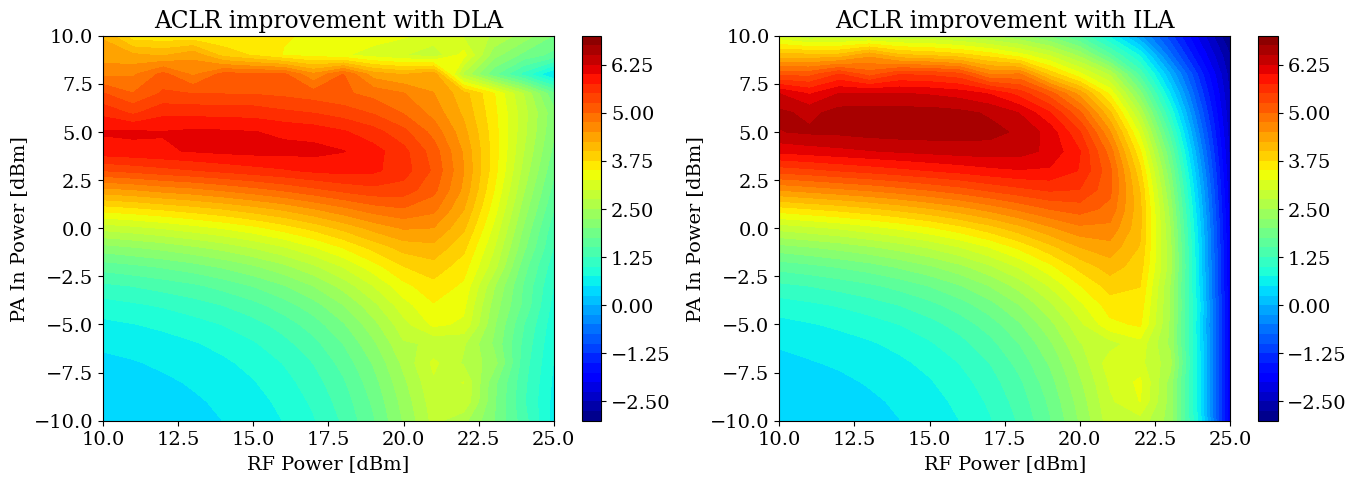

In [29]:
X, Y = np.meshgrid(powerRF_sweep, powerInPA_sweep)

# SNR
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
Z1 = SNR_DLA - SNR_woDPD
Z2 = SNR_ILA - SNR_woDPD
cbarticks = np.arange(np.floor(Z1.min()) - 2, np.ceil(Z2.max()) + 0.5, 0.5)

snr_dla_plt = axs[0].contourf(X, Y, Z1, cbarticks, cmap = 'jet')
axs[0].set_title('SNR improvement with DLA')
axs[0].set_ylabel('PA In Power [dBm]')
axs[0].set_xlabel('RF Power [dBm]')
plt.colorbar(snr_dla_plt, ax = axs[0])

snr_ila_plt = axs[1].contourf(X, Y, Z2, cbarticks, cmap = 'jet')
axs[1].set_title('SNR improvement with ILA')
axs[1].set_ylabel('PA In Power [dBm]')
axs[1].set_xlabel('RF Power [dBm]')
plt.colorbar(snr_ila_plt, ax = axs[1])

# EVM
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
Z1 = EVM_woDPD - EVM_DLA
Z2 = EVM_woDPD - EVM_ILA
cbarticks = np.arange(np.floor(Z1.min()) - 2, np.ceil(Z2.max()) + 0.5, 0.5)

evm_dla_plt = axs[0].contourf(X, Y, Z1, cbarticks, cmap = 'jet', antialiased = False)
axs[0].set_title('EVM improvement with DLA')
axs[0].set_ylabel('PA In Power [dBm]')
axs[0].set_xlabel('RF Power [dBm]')
plt.colorbar(evm_dla_plt, ax = axs[0])

evm_ila_plt = axs[1].contourf(X, Y, Z2, cbarticks, cmap = 'jet', antialiased = False)
axs[1].set_title('EVM improvement with ILA')
axs[1].set_ylabel('PA In Power [dBm]')
axs[1].set_xlabel('RF Power [dBm]')
plt.colorbar(evm_ila_plt, ax = axs[1])

# ACLR
fig, axs = plt.subplots(1, 2, figsize = (16, 5))
Z1 = ACLR_woDPD - ACLR_DLA
Z2 = ACLR_woDPD - ACLR_ILA
cbarticks = np.arange(np.floor(Z1.min()) - 3, np.ceil(Z2.max()) + 0.25, 0.25)

aclr_dla_plt = axs[0].contourf(X, Y, Z1, cbarticks, cmap = 'jet', antialiased = False)
axs[0].set_title('ACLR improvement with DLA')
axs[0].set_ylabel('PA In Power [dBm]')
axs[0].set_xlabel('RF Power [dBm]')
plt.colorbar(aclr_dla_plt, ax = axs[0])

aclr_ila_plt = axs[1].contourf(X, Y, Z2, cbarticks, cmap = 'jet', antialiased=False)
axs[1].set_title('ACLR improvement with ILA')
axs[1].set_ylabel('PA In Power [dBm]')
axs[1].set_xlabel('RF Power [dBm]')
plt.colorbar(aclr_ila_plt, ax = axs[1])